# 1. Import the required libraries

In [1]:
# Standard code libraries
import os
import matplotlib.pyplot as plt
import numpy as np

# Custom code libraries from ReSurfEMG
from resurfemg.data_connector.config import Config
from resurfemg.data_connector import file_discovery
from resurfemg.postprocessing import features as feat
from resurfemg.postprocessing import quality_assessment as qa
from resurfemg.pipelines import ipy_widgets
from resurfemg.data_connector.tmsisdk_lite import Poly5Reader
from resurfemg.data_connector.data_classes import (
VentilatorDataGroup, EmgDataGroup)

%matplotlib widget

## 2. Load the ventilator and sEMG data

In [2]:
# Identify all recordings available for the selected patient/measurement_date

# First find the patients
config = Config()

# Then find the files for the selected patients:
base_path = config.get_directory('seismic_data')
folder_levels = None

emg_files = file_discovery.find_files(
    base_path=base_path,
    file_name_regex='two_track_emg*',
    extension_regex='npy',
    folder_levels=None)

folder_levels = ['date', 'measurement']
vent_files = file_discovery.find_files(
    base_path=base_path,
    file_name_regex='paw_*',
    extension_regex='npy',
    folder_levels=None)

In [3]:
# If you want to select another file:
btn_list_emg = ipy_widgets.file_select(
    emg_files,
    folder_levels=['files'],
    default_value_select=None,
    default_idx_select=[0])
btn_list_vent = ipy_widgets.file_select(
    vent_files,
    folder_levels=['files'],
    default_value_select=None,
    default_idx_select=[0])

interactive(children=(Dropdown(description='files:', options=('two_track_emg_001_t0.npy', 'two_track_emg_001_t…

interactive(children=(Dropdown(description='files:', options=('paw_001_t0.npy', 'paw_001_t1.npy', 'paw_001_t24…

In [4]:
# Load the EMG and ventilator data recordings from the selected folders.
emg_file_chosen = os.path.join(base_path, emg_files['files'].values[0])
vent_file_chosen = os.path.join(base_path, vent_files['files'].values[0])
# Alternatively:
# emg_file_chosen = os.path.join(base_path, *[btn.value for btn in btn_list_emg])
# vent_file_chosen = os.path.join(base_path, *[btn.value for btn in btn_list_vent])
import resurfemg.data_connector.converter_functions as cf
#data_emg = cf.load_file(emg_file_chosen)
#data_vent = cf.load_file(vent_file_chosen)
#data_emg_samples = data_emg.samples[:data_emg.num_samples]
#fs_emg = data_emg.sample_rate
fs_emg=2048
#data_vent_samples = data_vent.samples[:data_vent.num_samples]
#fs_vent = data_vent.sample_rate
fs_vent=100
data_emg_samples = np.load(emg_file_chosen)
data_vent_samples = np.load(vent_file_chosen)
# Define the time series of the EMG and ventilator recordings
y_emg = data_emg_samples
y_vent = data_vent_samples

# Define the time axes
t_emg = [i/fs_emg for i in range(len(y_emg[0, :]))]
t_vent = [i/fs_vent for i in range(len(y_vent[0, :]))]

In [5]:
from resurfemg.preprocessing import filtering as filt
y80=filt.emg_bandpass_butter(y_emg[1,:],80,500,fs_emg)

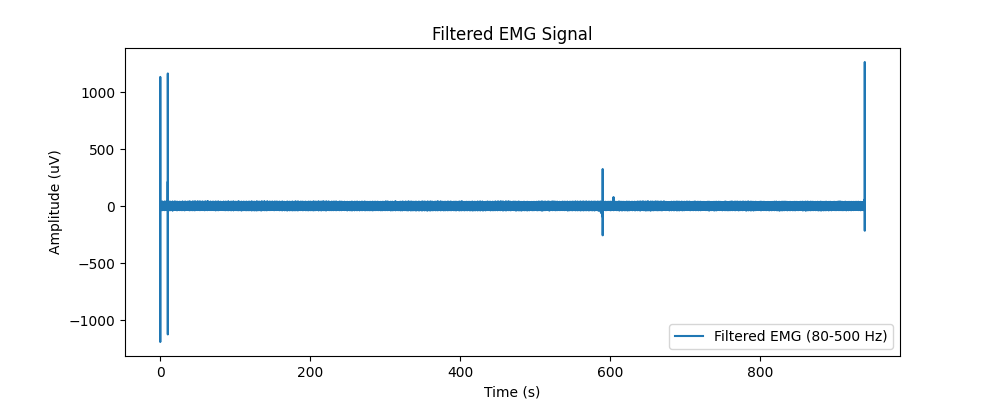

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(t_emg, y80, label='Filtered EMG (80-500 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.title('Filtered EMG Signal')
plt.legend()
plt.show()

In [7]:
# Store the EMG data in a group of TimeSeries objects
emg_timeseries = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=['EMGdi', 'EMGic'],
    units=2*['uV'])

No ECG channel detected. Set ECG channel index with `EmgDataGroup.set_ecg_idx(arg)` method.


In [8]:
# Store the ventilator data in a group of TimeSeries objects
vent_timeseries = VentilatorDataGroup(
    y_vent,
    fs=fs_vent,
    labels=['Paw'],
    units=['cmH2O'])

Auto-detected Pvent channel from labels.


In [9]:
attributes = dir(emg_timeseries)
print(attributes)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_available_methods', 'channels', 'ecg_idx', 'labels', 'param', 'run', 'set_ecg_idx', 'y_units']


# 3. Pre-process the data

In [10]:
# Filter
emg_timeseries.run('filter_emg',hp_cf=80,lp_cf=500)

In [ ]:
from resurfemg.preprocessing import filtering as filt
from resurfemg.preprocessing import ecg_removal as ecg_rm

#piekdetectie op kanaal 1 (intercostaal) - ecg_peak_idxs in gating stoppen
ts_0 = emg_timeseries.channels[1]
y_0 = ts_0.y_raw + 0
ecg_raw_test = filt.emg_bandpass_butter(
                    y_0, high_pass=20, low_pass=200, fs_emg=emg_timeseries.param['fs'])

ecg_peak_idxs_test = ecg_rm.detect_ecg_peaks(
                peak_fraction=0.01,
                ecg_raw=ecg_raw_test,
                fs=fs_emg,
                bp_filter=True)

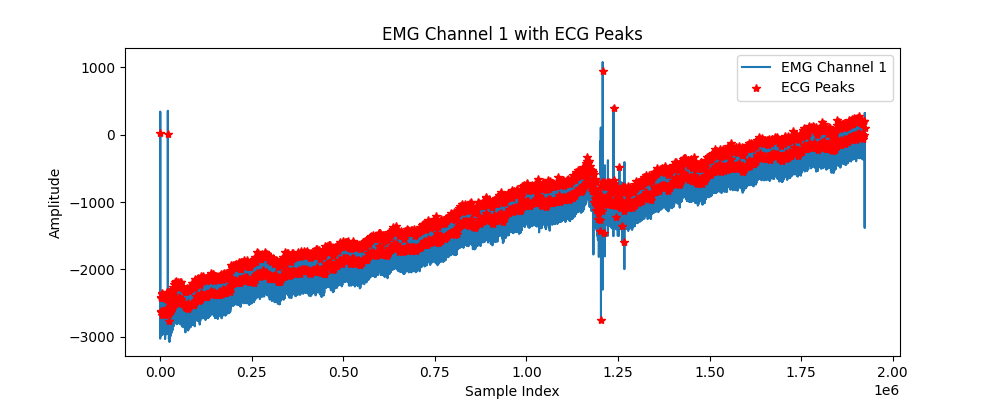

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(y_0, label='EMG Channel 1')
plt.plot(ecg_peak_idxs_test, y_0[ecg_peak_idxs_test], 'r*', label='ECG Peaks')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('EMG Channel 1 with ECG Peaks')
plt.legend()
plt.show()

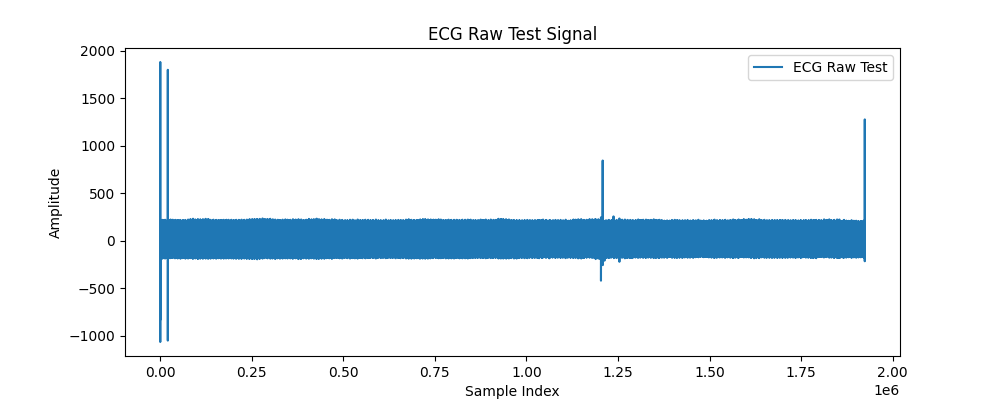

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(ecg_raw_test, label='ECG Raw Test')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('ECG Raw Test Signal')
plt.legend()
plt.show()

In [14]:
# # Through gating
emg_timeseries.run('gating',
    ecg_raw = None,
    gate_width_samples=fs_emg//4,
    ecg_peak_idxs = ecg_peak_idxs_test)

#emg_timeseries.ecg_idx=1
#emg_timeseries.gating(overwrite=True)
# Through wavelet denoising
#emg_timeseries.wavelet_denoising(overwrite=True)
# emg_timeseries.wavelet_denoising(n=8, fixed_threshold=8.0, overwrite=True)

Provided ECG peak indices used for ECG removal.


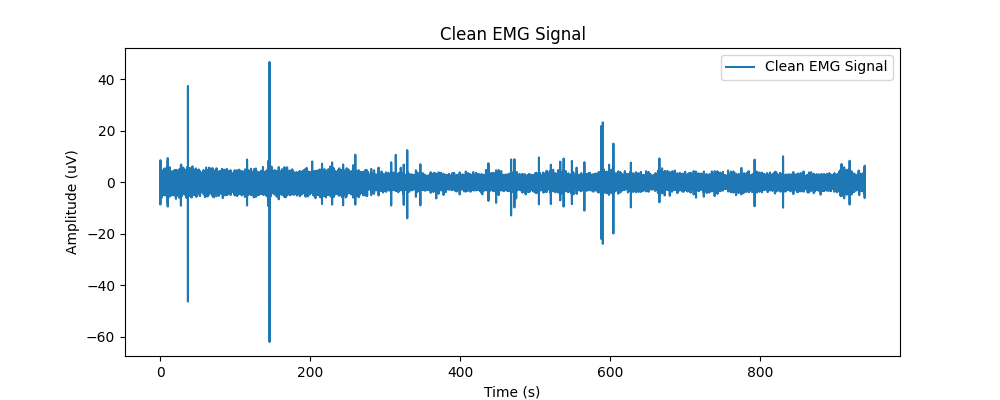

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(t_emg, emg_timeseries.channels[0].y_clean, label='Clean EMG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.title('Clean EMG Signal')
plt.legend()
plt.show()

In [16]:
# Calculate the envelope of the signal
emg_timeseries.run('envelope')
# emg_timeseries.envelope(env_type='arv')

In [17]:
# Calculate the baseline for the EMG envelopes and p_vent
emg_timeseries.run('baseline')
vent_timeseries.run('baseline',
    channel_idxs=[0],
    signal_type='raw')

In [18]:
emg_timeseries.channels[0].y_clean

array([4.07347356, 4.07246587, 4.071487  , ..., 2.56745716, 2.56856748,
       2.56967563])

(300.0, 410.0)

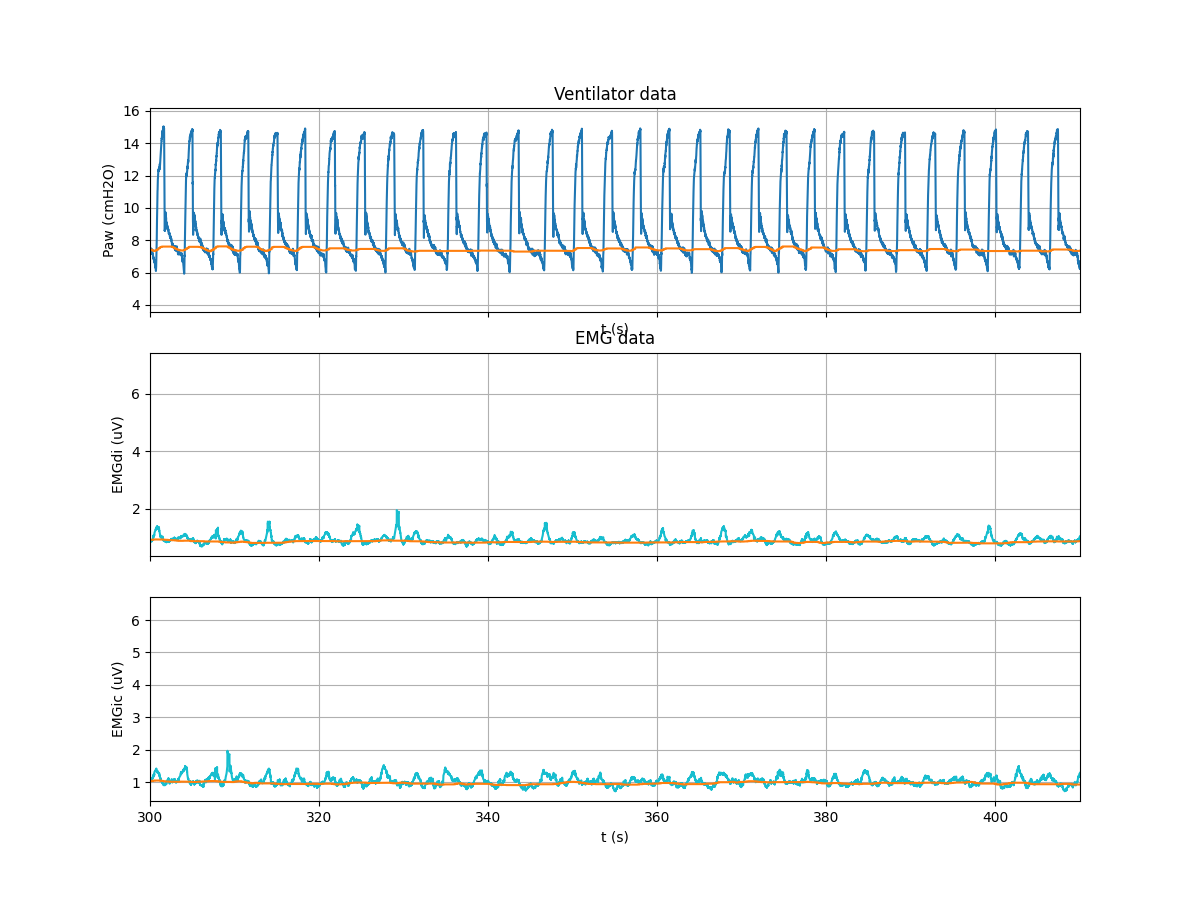

In [19]:
# Plot the raw data with the envelope
# EMG data
fig, axis = plt.subplots(nrows=3, ncols=1, figsize=(12, 9), sharex=True)
axes_vent = axis[0]
axes_emg = axis[1:]

# Plot ventilator data
vent_timeseries.run('plot_full', axes=[axes_vent])
axes_vent.set_title('Ventilator data')
axes_vent.set_xlabel('t (s)')

# Plot EMG data
colors = ['tab:cyan', 'tab:orange']
emg_timeseries.run('plot_full', axes=axes_emg, signal_type='env', colors=colors)
axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

# Adjust x-axis limits
axes_vent.set_xlim([300, 410])


In [20]:
# Find peaks in the ventilator data
from resurfemg.postprocessing import event_detection as ed

# Ensure v_vent_idx is set
vent_timeseries.v_vent_idx = 0  # Set to the correct index of the ventilator channel

v_vent = vent_timeseries.channels[vent_timeseries.v_vent_idx]
vent_timeseries.find_tidal_volume_peaks()
tv_idxs = v_vent.peaks['ventilator_breaths'].peak_df['peak_idx'].to_numpy()

In [21]:
# Initialize an empty list to store the indices of the lowest points
lowest_points = []

# Iterate through the peaks and find the lowest point between each pair of peaks
for i in range(len(tv_idxs) - 1):
    start, end = tv_idxs[i], tv_idxs[i + 1]
    lowest_point = np.argmin(y_vent[0, start:end]) + start
    lowest_points.append(lowest_point)

# Convert the list to a numpy array
lowest_points = np.array(lowest_points)

(300.0, 320.0)

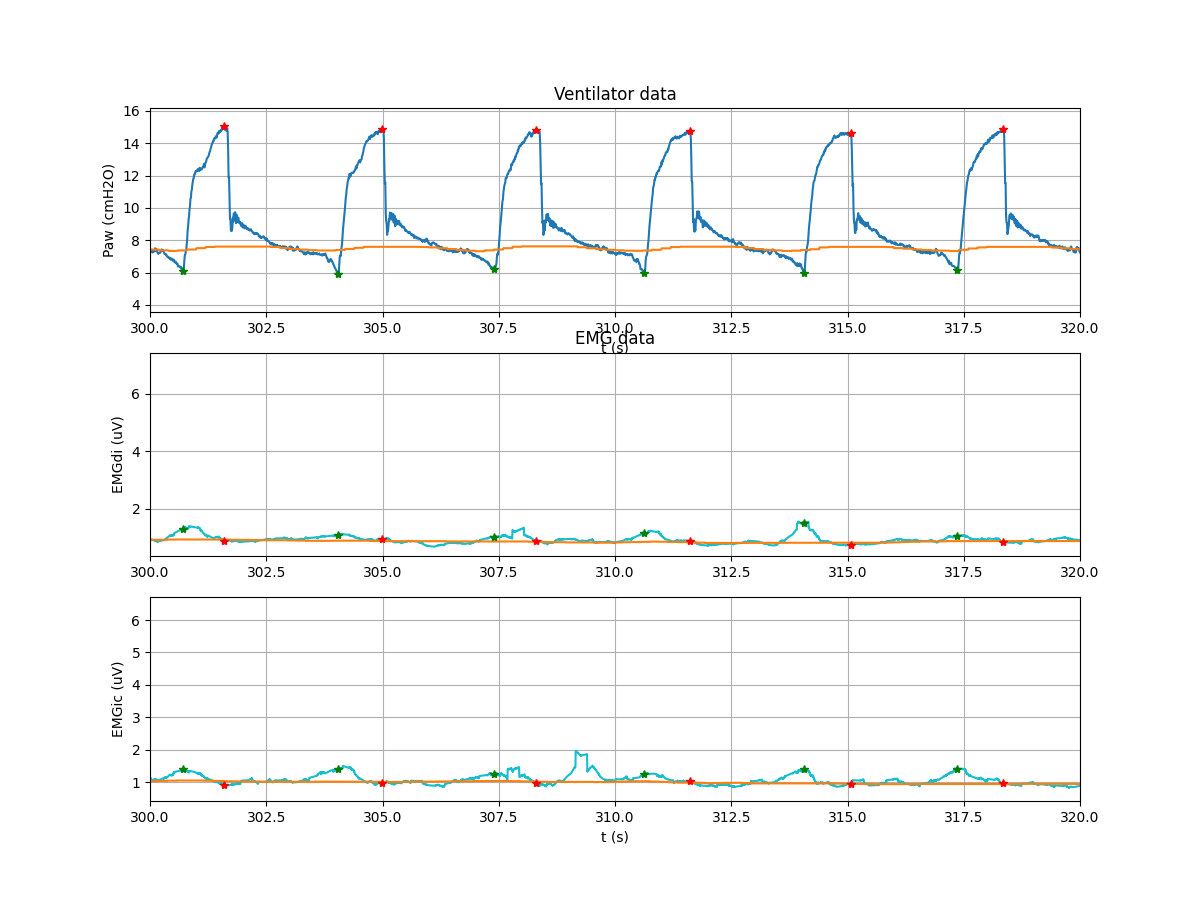

In [22]:
# Plot the raw data with the envelope
# EMG data
fig, axis = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))
axes_vent = axis[0]
axes_emg = axis[1:]

# Plot ventilator data
vent_timeseries.run('plot_full', axes=[axes_vent])
axes_vent.plot(np.array(t_vent)[tv_idxs], y_vent[0, tv_idxs], 'r*', label='Tidal Volume Peaks')
axes_vent.set_title('Ventilator data')
axes_vent.plot(np.array(t_vent)[lowest_points], y_vent[0, lowest_points], 'g*', label='Tidal Volume Peaks')
axes_vent.set_xlabel('t (s)')

# Plot EMG data
colors = ['tab:cyan', 'tab:orange']
emg_timeseries.run('plot_full', axes=axes_emg, signal_type='env', colors=colors)
# Recalculate tv_idxs to the sample frequency of the EMG
tv_idxs_emg = (tv_idxs * (fs_emg / fs_vent)).astype(int)
lowest_point_emg = (lowest_points * (fs_emg / fs_vent)).astype(int)


# Plot the recalculated tidal volume peaks on the EMG data
axes_emg[0].plot(np.array(t_emg)[tv_idxs_emg], emg_timeseries.channels[0].y_env[tv_idxs_emg], 'r*', label='Tidal Volume Peaks (Recalculated)')
axes_emg[1].plot(np.array(t_emg)[tv_idxs_emg], emg_timeseries.channels[1].y_env[tv_idxs_emg], 'r*', label='Tidal Volume Peaks (Recalculated)')
axes_emg[0].plot(np.array(t_emg)[lowest_point_emg], emg_timeseries.channels[0].y_env[lowest_point_emg], 'g*', label='Tidal Volume Peaks (Recalculated)')
axes_emg[1].plot(np.array(t_emg)[lowest_point_emg], emg_timeseries.channels[1].y_env[lowest_point_emg], 'g*', label='Tidal Volume Peaks (Recalculated)')
axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')
# Adjust x-axis limits
# Adjust x-axis limits
axes_vent.set_xlim([300, 320])
axes_emg[0].set_xlim([300, 320])
axes_emg[1].set_xlim([300, 320])


# 4. Identify all sEMG breaths, and find those closest to the ventilator breaths

In [23]:
# Find sEAdi peaks in one channel (sEAdi)
emg_di = emg_timeseries.channels[1]
emg_di.detect_emg_breaths(peak_set_name='breaths')

# Similar to above for Pocc and ventilator breaths:
emg_di.peaks['breaths'].detect_on_offset(
    baseline=emg_di.y_baseline
)

In [38]:
help(emg_di.link_peak_set)

Help on method link_peak_set in module resurfemg.data_connector.data_classes:

link_peak_set(peak_set_name, t_reference_peaks, linked_peak_set_name=None) method of resurfemg.data_connector.data_classes.TimeSeries instance
    Find the peaks in the PeaksSet with the peak_set_name closest in time
    to the provided peak timings in t_reference_peaks
    -----------------------------------------------------------------------
    :param peak_set_name: PeaksSet name in self.peaks dict
    :type peak_set_name: str
    :param t_reference_peaks: Refernce peak timings in t_reference_peaks
    :type t_reference_peaks: ~numpy.ndarray
    :param linked_peak_set_name: Name of the new PeaksSet
    :type linked_peak_set_name: str
    
    :return: None
    :rtype: None



In [ ]:
# Find the EMG peaks with the peak timing closest to the ventilator breaths, and
# link ventilator breaths to EMG breaths
t_vent_peaks = p_vent.peaks['breaths'].peak_df['peak_idx'].to_numpy() / p_vent.param['fs']

emg_di.link_peak_set(
    peak_set_name='breaths',
    t_reference_peaks=t_vent_peaks,
    linked_peak_set_name='async',
)



The timings of the Pocc peaks is in sEMGdi are at:
0    373.447266
1    389.692383
2    403.416992
Name: start_idx, dtype: float64
0    764820
1    798090
2    826198
Name: start_idx, dtype: int64


(np.float64(370.0), np.float64(410.0), np.float64(0.0), np.float64(1.0))

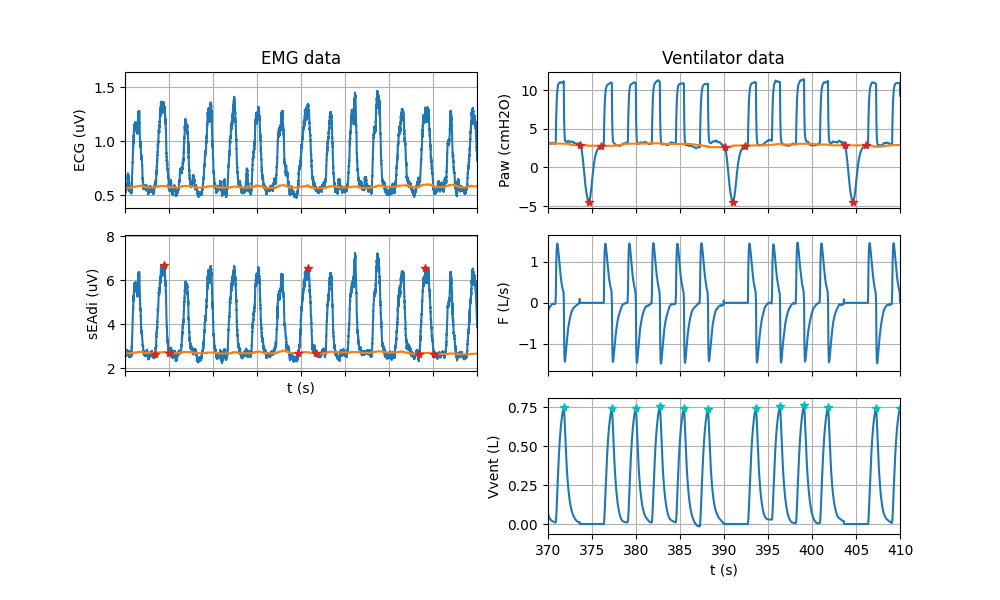

In [ ]:
# Plot the identified Pocc peaks in p_vent and sEAdi
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)
axes_emg = axis[:-1, 0]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_timeseries.plot_full(axes_emg, signal_type='env')
emg_di.plot_markers(peak_set_name='Pocc', axes=axes_emg[1])


axes_emg[1].set_ylabel('sEAdi (uV)')
axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

axes_vent = axis[:, 1]
vent_timeseries.plot_full(axes_vent)
p_vent.plot_markers(peak_set_name='Pocc', axes=axes_vent[0])
v_vent.plot_markers(peak_set_name='ventilator_breaths',
                    axes=axes_vent[2], colors='c')

axes_vent[0].set_title('Ventilator data')
axes_vent[-1].set_xlabel('t (s)')
axes_vent[-1].set_xlim([370, 410])

axis[-1, 0].axis('off')

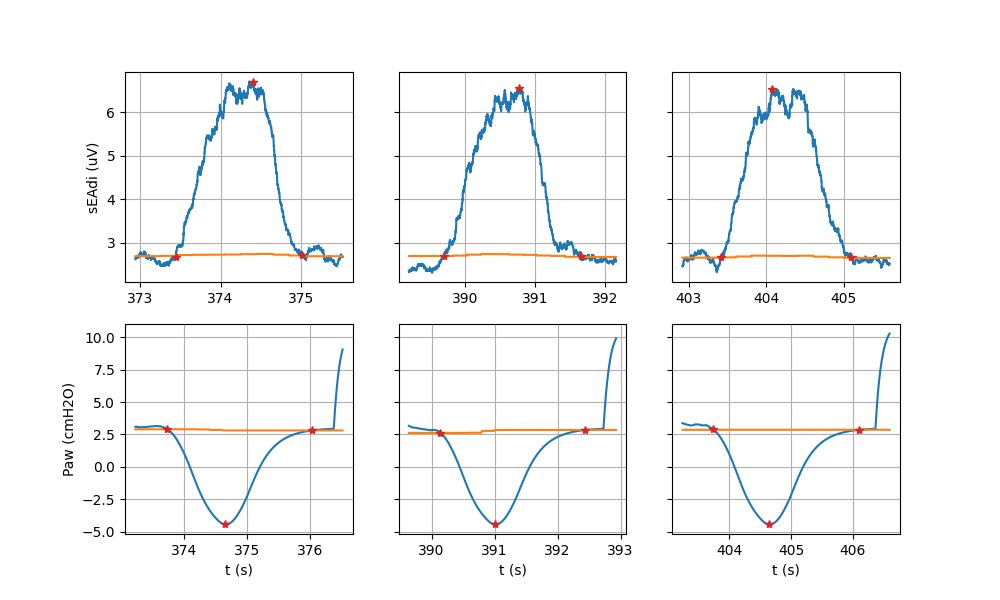

In [ ]:
# Plot the individual peaks
n_peaks = len(emg_di.peaks['Pocc'].peak_df['start_idx'].to_numpy())
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(10, 6), sharey='row')

axes_emg = axis[0, :]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='Pocc')
emg_di.plot_markers(axes=axes_emg, peak_set_name='Pocc')
axes_emg[0].set_ylabel('sEAdi (uV)')

axes_vent = axis[1, :]
p_vent.plot_peaks(axes=axes_vent, peak_set_name='Pocc')
p_vent.plot_markers(axes=axes_vent, peak_set_name='Pocc')

for axis in axes_vent:
    axis.set_xlabel('t (s)')

# 5. Calculate features

In [21]:
# Respiratory rates
tv_idxs = v_vent.peaks['ventilator_breaths'].peak_df['peak_idx'].to_numpy()
rr_vent, _ = feat.respiratory_rate(
    tv_idxs, fs_vent
)

rr_vent, _ = feat.respiratory_rate(
    v_vent.peaks['ventilator_breaths'].peak_df['peak_idx'].to_numpy(),
    v_vent.param['fs'])
v_vent.param['rr'] = rr_vent
p_vent.param['rr'] = rr_vent
print('The detected respiratory rate in the ventilator data is: '
      + f'{round(rr_vent, 1)} /min')

emg_di_idxs = emg_di.peaks['breaths'].peak_df['peak_idx'].to_numpy()
rr_emg, _ = feat.respiratory_rate(
    emg_di_idxs, fs_emg
)
emg_di.param['rr'] = rr_emg
print('The detected respiratory rate in the sEAdi data is: '
      + f'{round(rr_emg, 1)} /min')

The detected respiratory rate in the ventilator data is: 22.0 /min
The detected respiratory rate in the sEAdi data is: 22.0 /min


In [22]:
# EMG amplitudes
emg_di_pocc_idxs = emg_di.peaks['Pocc'].peak_df['peak_idx'].to_numpy()
sEAdi_amplitudes = feat.amplitude(
    signal=emg_di.y_env,
    peak_idxs=emg_di_pocc_idxs,
    baseline=emg_di.y_baseline,
)
print('The sEAdi amplitudes are:')
print(sEAdi_amplitudes)

The sEAdi amplitudes are:
[3.97351188 3.84477595 3.84752319]


In [ ]:
# Calculate PTPocc
p_vent.calculate_time_products(
    peak_set_name='Pocc',
    aub_reference_signal=p_vent.y_baseline,
    parameter_name='PTPocc')
print(p_vent.peaks['Pocc'].peak_df)

   peak_idx  start_idx  end_idx  valid       AUB  aub_y_ref    PTPocc
0     37465      37372    37602   True  0.629043   3.112269  7.967947
1     39101      39014    39244   True  0.612831   3.043785  7.816193
2     40465      40374    40611   True  0.503030   3.074270  7.895531


In [24]:
# Calculate ETPdi
emg_di.calculate_time_products(
    peak_set_name='Pocc', parameter_name='ETPdi')

print(emg_di.peaks['Pocc'].peak_df)

   peak_idx  start_idx  end_idx  valid       AUB  aub_y_ref     ETPdi
0    766766     764820   768017   True  0.705273   2.275619  4.264154
1    800300     798090   802124   True  0.786705   2.314840  4.598744
2    827555     826198   829630   True  0.609709   2.322489  4.319325


# 6. Test Pocc and sEMG quality

In [25]:
# Test general signal characteristics
fraction_emg_breaths, _ = qa.evaluate_respiratory_rates(
    emg_breath_idxs=emg_di_idxs,
    t_emg=max(emg_di.t_data),
    rr_vent=rr_vent
)
print('The fraction detected EMG breaths is: {:0.2f} %'.format(
    100*fraction_emg_breaths))

The fraction detected EMG breaths is: 100.10 %


In [ ]:
# Test Pocc quality
parameter_names = {
    'time_product': 'PTPocc'
}
p_vent.test_pocc_quality(
    peak_set_name='Pocc',
    parameter_names=parameter_names,
    verbose=True)

Test values:
   peak_idx  dP_up_10  dP_up_90  dP_up_90_norm
0     37465  0.009708  0.110633       0.039193
1     39101  0.008363  0.109885       0.039304
2     40465  0.007633  0.109652       0.039023
Test outcomes:
   peak_idx  baseline_detection  consecutive_poccs  pocc_upslope
0     37465                True               True          True
1     39101                True               True          True
2     40465                True               True          True


In [27]:
# The peak-validity is updated in the peak_df:
print(p_vent.peaks['Pocc'].peak_df)

   peak_idx  start_idx  end_idx  valid       AUB  aub_y_ref    PTPocc
0     37465      37372    37602   True  0.629043   3.112269  7.967947
1     39101      39014    39244   True  0.612831   3.043785  7.816193
2     40465      40374    40611   True  0.503030   3.074270  7.895531


In [ ]:
# Test EMG quality
parameter_names = {
    'time_product': 'ETPdi'
}
emg_di.test_emg_quality(
    peak_set_name='Pocc', parameter_names=parameter_names, verbose=False)

In [29]:
# Test the ventilatory Pocc peaks against the EMG peaks
p_vent.param['rr_occ'] = 60*len(p_vent.peaks['Pocc'].peak_df)/(p_vent.t_data[-1])
cutoff = {
    'fraction_emg_breaths': 0.1,
    'delta_min': 0.5*rr_vent/60,
    'delta_max': 0.6
}
parameter_names = {
    'rr': 'rr_occ'
}

emg_di.test_linked_peak_sets(
    peak_set_name='Pocc',
    linked_timeseries=p_vent,
    linked_peak_set_name='Pocc',
    verbose=True,
    cutoff=cutoff,
    parameter_names=parameter_names,
)

Test values:
   peak_idx       snr        aub  aub_y_refs       bell  detected_fraction  \
0    766766  2.463920  16.539567    2.275619  10.094759           0.999977   
1    800300  2.428406  17.106957    2.314840  10.264365           0.999977   
2    827555  2.442339  14.115832    2.322489   9.215461           0.999977   

   event_delta_time  
0          0.252539  
1          0.238516  
2          0.570410  
Test outcomes:
   peak_idx  baseline_detection  interpeak_distance   snr   aub  bell  \
0    766766                True                True  True  True  True   
1    800300                True                True  True  True  True   
2    827555                True                True  True  True  True   

   relative_aub  relative_etp  detected_fraction  event_timing  
0          True          True               True          True  
1          True          True               True          True  
2          True          True               True          True  


In [30]:
# The peak-validity is updated in the peak_df:
print(emg_di.peaks['Pocc'].peak_df)

   peak_idx  start_idx  end_idx  valid       AUB  aub_y_ref     ETPdi  \
0    766766     764820   768017   True  0.705273   2.275619  4.264154   
1    800300     798090   802124   True  0.786705   2.314840  4.598744   
2    827555     826198   829630   True  0.609709   2.322489  4.319325   

   bell_y_min    bell_a      bell_b    bell_c  
0    2.275619  4.530913  374.231763  0.563334  
1    2.314840  4.274583  390.588789  0.628609  
2    2.322489  4.312252  404.206156  0.599920  


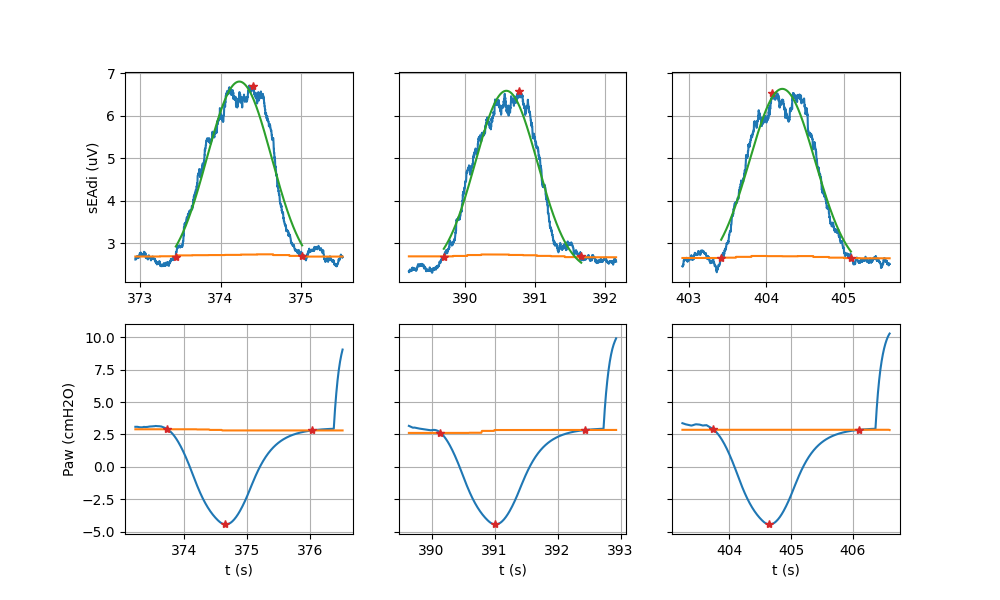

In [ ]:
# Plot the individual peaks bell-fit
n_peaks = len(emg_di.peaks['Pocc'].peak_df['start_idx'].to_numpy())
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(10, 6), sharey='row')

axes_emg = axis[0, :]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='Pocc')
emg_di.plot_markers(axes=axes_emg, peak_set_name='Pocc')
emg_di.plot_curve_fits(axes=axes_emg, peak_set_name='Pocc')
axes_emg[0].set_ylabel('sEAdi (uV)')

axes_vent = axis[1, :]
p_vent.plot_peaks(axes=axes_vent, peak_set_name='Pocc')
p_vent.plot_markers(axes=axes_vent, peak_set_name='Pocc')

for axis in axes_vent:
    axis.set_xlabel('t (s)')

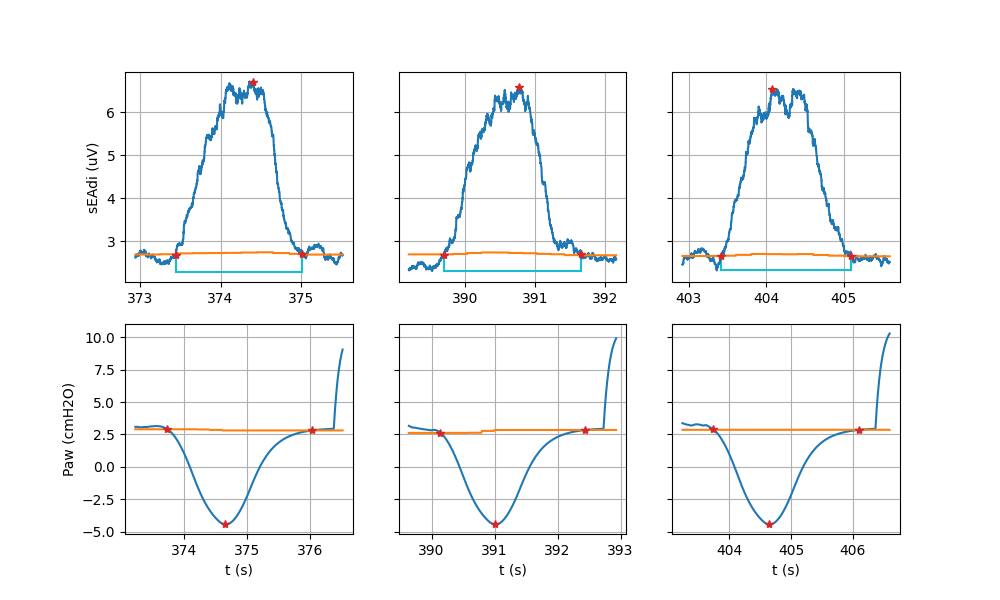

In [ ]:
# Plot the individual peaks area under the baseline
n_peaks = len(emg_di.peaks['Pocc'].peak_df['start_idx'].to_numpy())
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(10, 6), sharey='row')

axes_emg = axis[0, :]
emg_di.plot_aub(axes=axes_emg, signal_type='env', peak_set_name='Pocc')
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='Pocc')
emg_di.plot_markers(axes=axes_emg, peak_set_name='Pocc')
axes_emg[0].set_ylabel('sEAdi (uV)')

axes_vent = axis[1, :]
p_vent.plot_peaks(axes=axes_vent, peak_set_name='Pocc')
p_vent.plot_markers(axes=axes_vent, peak_set_name='Pocc')

for axis in axes_vent:
    axis.set_xlabel('t (s)')